In [1]:
# run this only after Kernel restart

import os
if os.getcwd().split("/")[-1] != "neurolib":
    os.chdir('..')

os.chdir('..')
datadir = os.path.join(os.getcwd(), "neurolib", "notebooks_frontiers24")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from numba.typed import Dict
from numba.core import types

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel

from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc, cost_functions

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

weights = Dict.empty(
        key_type=types.unicode_type,
        value_type=types.float64,
    )

weights["w_2"] = 1.0
weights["w_1D"] = 0.0

def plot_control(control, state, dur, dt):
    fig, ax = plt.subplots(2,1, figsize=(16,8), sharex=True)
    time_array = np.arange(0, dur+dt, dt)

    for n in range(N):
        ax[0].plot(time_array, state[n,0,:])
        ax[1].plot(time_array, control[n,0,:])

    ax[0].set_xlim(0, dur)

    ax[1].set_xlabel("Time")
    ax[0].set_ylabel("Activity")
    ax[1].set_ylabel("Control")
    fig.align_ylabels([ax[:]])

    plt.show()
    return

def getperiod(data, dt):
    maxfreq = []
    for i_d,d in enumerate(data):
        ps = np.abs(np.fft.fft(d))
        ps_ = ps[:int(len(ps)/2)] / (len(ps)/2)
        ps_[0] = 0.
        fr = np.linspace(0,1./(2.*dt),len(ps_))
        maxfreqind = np.where(ps_ == max(ps_[1:]))
        maxfreq.append((1./fr[maxfreqind])[0])

    print(maxfreq)

    return np.median(maxfreq)

def set_weight_sync(model, method, weight):
    model.weights["w_p"] = 0.
    model.weights["w_2"] = 1.
    
    if method == "F":
        model.weights["w_f_sync"] = weight
    elif method == "CC":
        model.weights["w_cc"] = weight
    elif method == "VAR":
        model.weights["w_var"] = weight
    return

def optimize_model(model, exprange, it):
    for k in exprange:
        model.zero_step_encountered = False
        model.step = 10**(k)
        model.optimize(it)
    model.zero_step_encountered = False

    return

In [3]:
N = 6

cmat = np.array([[0., 1., 0., 0., 0., 1.],
 [1., 0., 1., 0., 1., 0.],
 [0., 0., 0., 0., 0., 1.],
 [0., 0., 1., 0., 0., 1.],
 [1., 1., 0., 1., 0., 1.],
 [0., 1., 1., 0., 0., 0.]])
dmat = np.array( [[ 0., 12.,  0.,  0.,  0.,  8.],
 [ 8.,  0., 13.,  0.,  1.,  0.],
 [ 0.,  0.,  0.,  0.,  0.,  9.],
 [ 0.,  0.,  4.,  0.,  0., 11.],
 [ 5., 17.,  0., 14.,  0., 18.],
 [ 0.,  0.,  3.,  0.,  0.,  0.]])

coupling = 0.8

In [4]:
coords_sync = [1.6, 0.4]

data_sync = dict()
data_sync["control"] = [None, None, None]
data_sync["state"] = [None, None, None]
data_sync["init"] = [None, None]
data_sync["weights"] = np.ones((3))
data_sync["control_cost"] = np.zeros((3))
data_sync["sync_cost"] = np.zeros((3))
data_sync["uncontrolled_state"] = None
data_sync["uncontrolled_cost"] = np.zeros((3))

In [5]:
model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.K_gl = coupling

dur = 3000.

model.params['duration'] = dur 
model.params.exc_ext_baseline = coords_sync[0]
model.params.inh_ext_baseline = coords_sync[1]
test_input = ZeroInput().generate_input(duration=dur+model.params.dt, dt=model.params.dt)
test_input[0,:int(100/model.params.dt)] = 3.
model.params["ext_exc_current"] = test_input
model.run()

maxdelay = model.getMaxDelay()

einit = np.zeros((N, maxdelay+1))
iinit = np.zeros((N, maxdelay+1))

for n in range(N):
    einit[n,:] = model.exc[n, -maxdelay-1:]
    iinit[n,:] = model.inh[n, -maxdelay-1:]

data_sync["init"][0] = einit
data_sync["init"][1] = iinit

minind = 20000
period_sync = getperiod( [model.exc[0,-minind:], model.exc[1,-minind:], model.exc[2,-minind:],
                              model.exc[3,-minind:], model.exc[4,-minind:], model.exc[5,-minind:]], model.params.dt)

[13.8875, 13.8875, 13.8875, 15.03609022556391, 18.18, 13.8875]


In [6]:
coords_desync = [1., 0.4]

data_desync = dict()

data_desync["control"] = [None, None, None]
data_desync["state"] = [None, None, None]
data_desync["init"] = [None, None]
data_desync["weights"] = np.ones((3))
data_desync["control_cost"] = np.zeros((3))
data_desync["sync_cost"] = np.zeros((3))
data_desync["uncontrolled_state"] = None
data_desync["uncontrolled_cost"] = np.zeros((3))

In [7]:
model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.K_gl = coupling

model.params['duration'] = dur 
model.params.exc_ext_baseline = coords_desync[0]
model.params.inh_ext_baseline = coords_desync[1]
model.params["ext_exc_current"] = test_input
model.run()

maxdelay = model.getMaxDelay()

einit = np.zeros((N, maxdelay+1))
iinit = np.zeros((N, maxdelay+1))

for n in range(N):
    einit[n,:] = model.exc[n, -maxdelay-1:]
    iinit[n,:] = model.inh[n, -maxdelay-1:]

data_desync["init"][0] = einit
data_desync["init"][1] = iinit

period_desync = getperiod( [model.exc[0,-10000:], model.exc[1,-10000:], model.exc[2,-10000:],
                              model.exc[3,-10000:], model.exc[4,-10000:], model.exc[5,-10000:]], model.params.dt)

[19.22692307692308, 19.22692307692308, 19.22692307692308, 19.22692307692308, 19.22692307692308, 19.22692307692308]


In [8]:
controlmat = np.zeros((N,2))
controlmat[:,0] = 1

costmat = np.zeros((N,2))
costmat[:,0] = 1

duration = 800
control_interval = [1000, -2000]
cost_interval = [1000, -2000]

max_cntrl = 5
pr = np.arange(0,101,10)

In [9]:
data_sync["weights"][0] = 2.02 * 1e4
data_sync["weights"][1] = 2.2 * 1e3
data_sync["weights"][2] = 1.422 * 1e4

In [12]:
with open(os.path.join(datadir, '3_3.pickle'), 'rb') as f:
    res_read = pickle.load(f)

[data_sync, data_desync] = res_read.copy()

In [11]:
model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.K_gl = coupling

model.params['duration'] = duration
model.params.exc_ext_baseline = coords_sync[0]
model.params.inh_ext_baseline = coords_sync[1]

model.params["exc_init"] = data_sync["init"][0]
model.params["inh_init"] = data_sync["init"][1]
model.run()

for mi, method in enumerate(["F", "CC", "VAR"]):
    if mi not in [0]: continue

    model_controlled = oc_wc.OcWc(model, period_sync, print_array=pr, cost_interval=cost_interval, control_interval=control_interval,
                                cost_matrix=costmat, control_matrix=controlmat)
    model_controlled.maximum_control_strength = max_cntrl

    model_controlled.optimize(0)
    model_controlled.channelwise_optimization = True

    if mi in [0,2]:
        data_sync["weights"][mi] *= 1000
        set_weight_sync(model_controlled, method, data_sync["weights"][mi])
        # find initial control signal with large f_F for a few iterations
        for k in range(3):
            optimize_model(model_controlled, np.arange(-4., 0., 1.), 4)
            data_sync["weights"][mi] /= 10.
            set_weight_sync(model_controlled, method, data_sync["weights"][mi])

    set_weight_sync(model_controlled, method, data_sync["weights"][mi])
    
    # find initial control signal
    optimize_model(model_controlled, np.arange(-7., 7., 2.), 10)

    model_controlled.grad_method = 1
    optimize_model(model_controlled, np.arange(-7., 7., 2.), 10)

    data_sync["control"][mi] = model_controlled.control.copy()
    data_sync["state"][mi] = model_controlled.get_xs()

    coc = cost_functions.control_strength_cost(data_sync["control"][mi], weights, model.params.dt)
    data_sync["control_cost"][mi] = coc
    data_sync["sync_cost"][mi] = (model_controlled.compute_total_cost() - coc)/data_sync["weights"][mi]

    plot_control(data_sync["control"][mi], data_sync["state"][mi], duration, model.params.dt)

Optimal control with target oscillation period
Compute control for a deterministic system


KeyboardInterrupt: 

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -2123.839600382438
Final cost : -2123.839600382438
Compute control for a deterministic system
Cost in iteration 0: -2123.839600382438
Converged in iteration 2 with cost -2123.839600382438
Final cost : -2123.839600382438
Compute control for a deterministic system
Cost in iteration 0: -2123.839600382438
Converged in iteration 1 with cost -2123.839600382438
Final cost : -2123.839600382438
Compute control for a deterministic system
Cost in iteration 0: -2123.839600382438
Converged in iteration 1 with cost -2123.839600382438
Final cost : -2123.839600382438
Compute control for a deterministic system
Cost in iteration 0: -2123.839600382438
Converged in iteration 1 with cost -2123.839600382438
Final cost : -2123.839600382438
Compute control for a deterministic system
Cost in iteration 0: -2123.839600382438
Converged in iteration 1 with cost -2123.839600382438
Final cost : -2123.839600

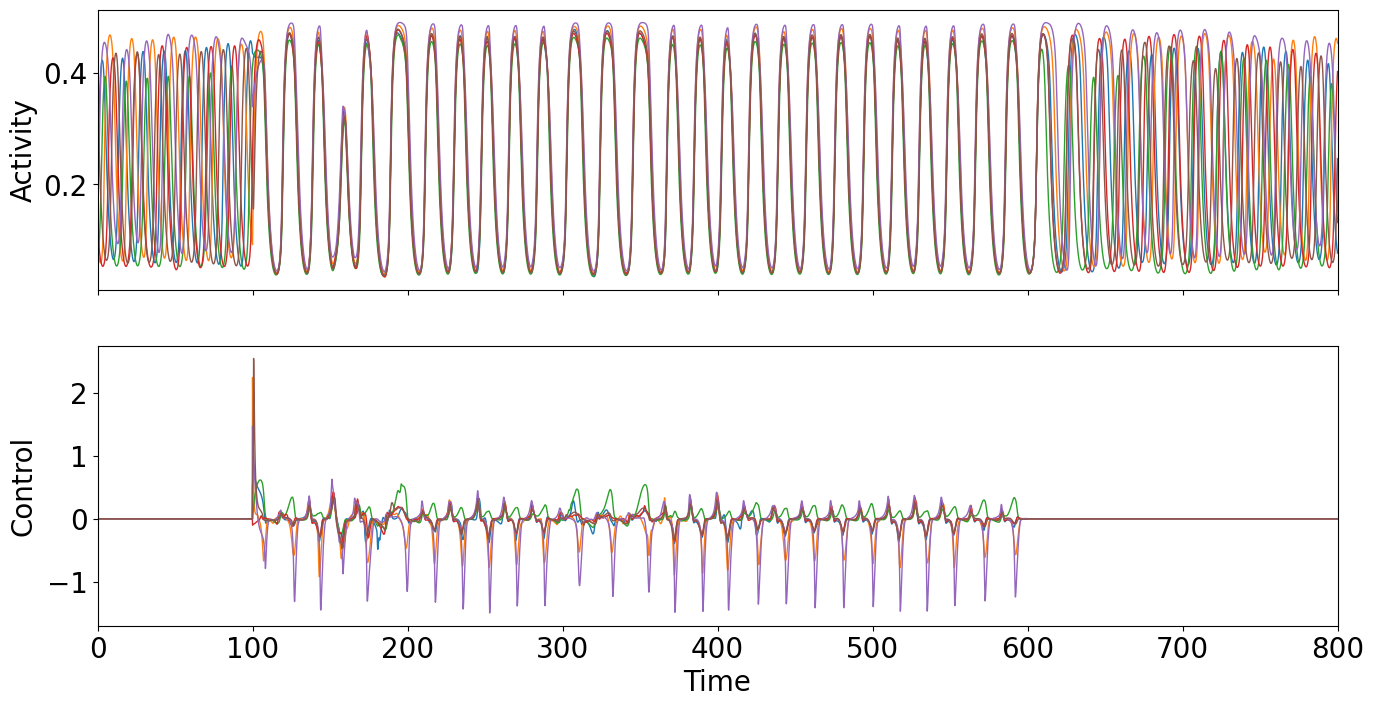

In [414]:
model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.K_gl = coupling

model.params['duration'] = duration
model.params.exc_ext_baseline = coords_sync[0]
model.params.inh_ext_baseline = coords_sync[1]

model.params["exc_init"] = data_sync["init"][0]
model.params["inh_init"] = data_sync["init"][1]

model.run()

for mi, method in enumerate(["F", "CC", "VAR"]):

    if mi not in [1]: continue

    model_controlled = oc_wc.OcWc(model, period_sync, print_array=pr, cost_interval=cost_interval, control_interval=control_interval,
                                cost_matrix=costmat, control_matrix=controlmat)
    
    set_weight_sync(model_controlled, method, data_sync["weights"][mi])
    model_controlled.maximum_control_strength = max_cntrl

    model_controlled.simulate_forward()
    data_sync["uncontrolled_state"] = model_controlled.get_xs()
    data_sync["uncontrolled_cost"][mi] = model_controlled.compute_total_cost()/data_sync["weights"][mi]

    model_controlled.control = data_sync["control"][mi].copy()
    model_controlled.update_input()

    model_controlled.optimize(0)
    model_controlled.channelwise_optimization = True

    for j in range(10):
        model_controlled.grad_method = 0
        optimize_model(model_controlled, np.arange(-5., 7., 2.), 20)

        model_controlled.grad_method = 1
        optimize_model(model_controlled, np.arange(-5., 7., 2.), 10)

    data_sync["control"][mi] = model_controlled.control.copy()
    data_sync["state"][mi] = model_controlled.get_xs()

    coc = cost_functions.control_strength_cost(data_sync["control"][mi], weights, model.params.dt)
    data_sync["control_cost"][mi] = coc
    data_sync["sync_cost"][mi] = (model_controlled.compute_total_cost() - coc)/data_sync["weights"][mi]

    plot_control(data_sync["control"][mi], data_sync["state"][mi], duration, model.params.dt)

In [415]:
with open(os.path.join(datadir, '3_3.pickle'), 'wb') as f:
    pickle.dump([data_sync, data_desync], f)

In [13]:
data_desync["weights"][0] = -1000.
data_desync["weights"][1] = -1200.
data_desync["weights"][2] = -2000.

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 17.10678936332824
Final cost : 17.10678936332824
Compute control for a deterministic system
Cost in iteration 0: 0.9607589223166733
Cost in iteration 10: 0.9506817975180452
Final cost : 0.9506817975180452
Compute control for a deterministic system
Cost in iteration 0: 0.9506817975180452
Cost in iteration 10: 0.1968353796434373
Final cost : 0.1968353796434373
Compute control for a deterministic system
Cost in iteration 0: 0.1968353796434373
Cost in iteration 10: 0.017807771882947274
Final cost : 0.017807771882947274
Compute control for a deterministic system
Cost in iteration 0: 0.017807771882947274
Converged in iteration 9 with cost 0.016409310141282
Final cost : 0.016409310141282
Compute control for a deterministic system
Cost in iteration 0: 0.016409310141282
Converged in iteration 2 with cost 0.016409310141282
Final cost : 0.016409310141282
Compute control for a determinist

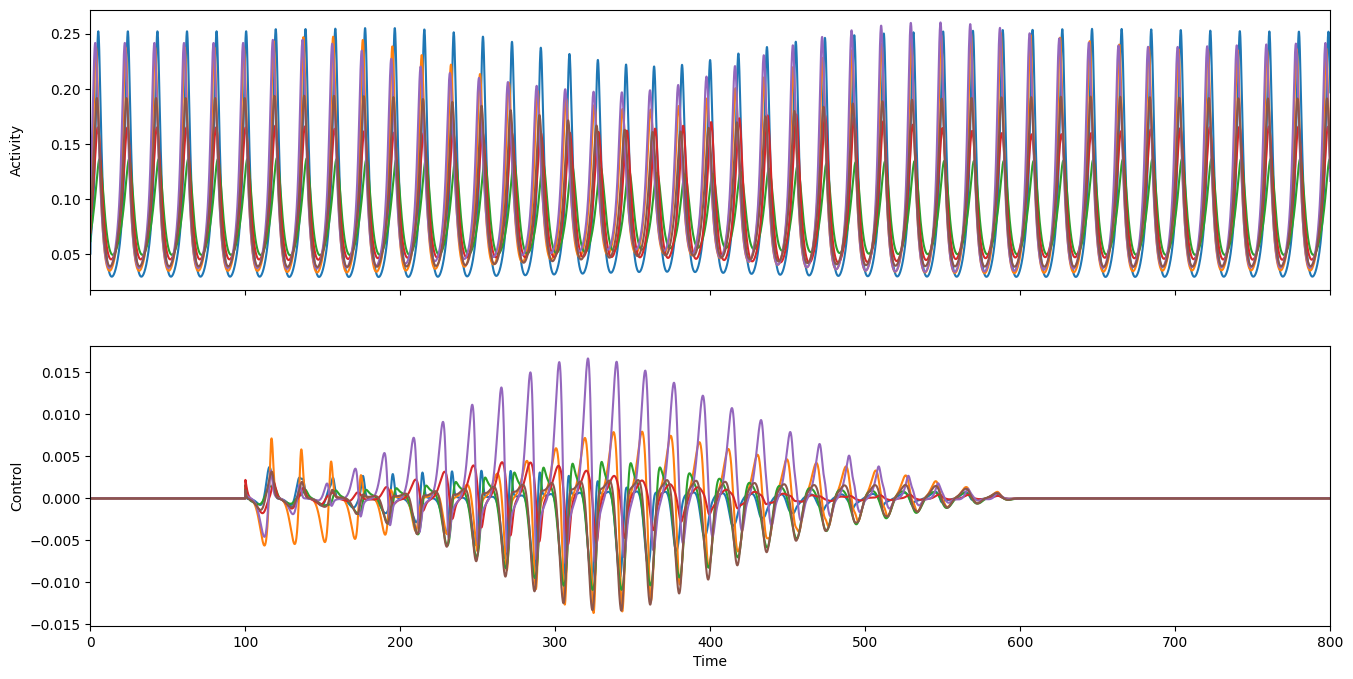

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 17.10678936332824
Final cost : 17.10678936332824
Compute control for a deterministic system
Cost in iteration 0: 1032.5087924490726
Cost in iteration 10: 990.8034975270357
Final cost : 990.8034975270357
Compute control for a deterministic system
Cost in iteration 0: 990.8034975270357
Cost in iteration 10: 88.31494093331705
Final cost : 88.31494093331705
Compute control for a deterministic system
Cost in iteration 0: 88.31494093331705
Cost in iteration 10: -109.55521336132023
Final cost : -109.55521336132023
Compute control for a deterministic system
Cost in iteration 0: -109.55521336132023
Converged in iteration 5 with cost -120.92264257645152
Final cost : -120.92264257645152
Compute control for a deterministic system
Cost in iteration 0: -120.92264257645152
Converged in iteration 2 with cost -120.92264257645152
Final cost : -120.92264257645152
Compute control for a determinis

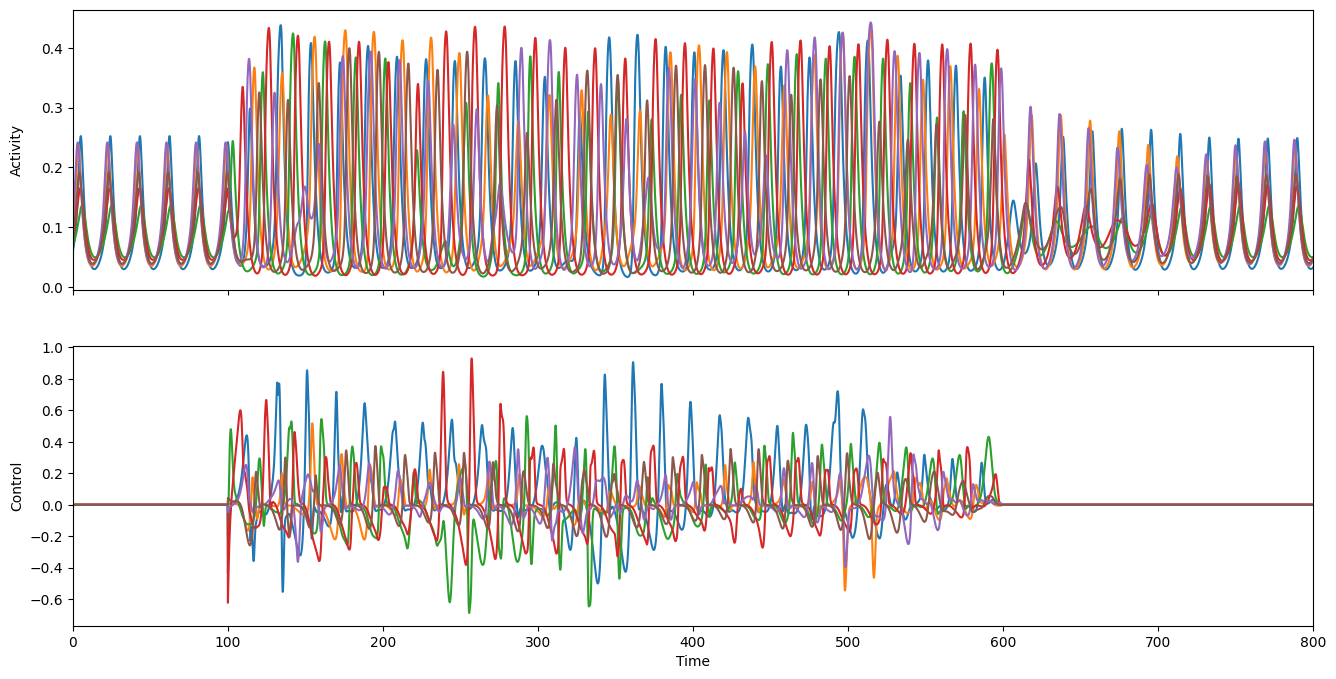

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 17.10678936332824
Final cost : 17.10678936332824
Compute control for a deterministic system
Cost in iteration 0: -1.1178306288434623
Cost in iteration 10: -1.1184099022175797
Final cost : -1.1184099022175797
Compute control for a deterministic system
Cost in iteration 0: -1.1184099022175797
Cost in iteration 10: -1.1816750931063613
Final cost : -1.1816750931063613
Compute control for a deterministic system
Cost in iteration 0: -1.1816750931063613
Cost in iteration 10: -8.828786089933143
Final cost : -8.828786089933143
Compute control for a deterministic system
Cost in iteration 0: -8.828786089933143
Cost in iteration 10: -11.335870932539208
Final cost : -11.335870932539208
Compute control for a deterministic system
Cost in iteration 0: -11.335870932539208
Cost in iteration 10: -11.612557863292867
Final cost : -11.612557863292867
Compute control for a deterministic system
Cost 

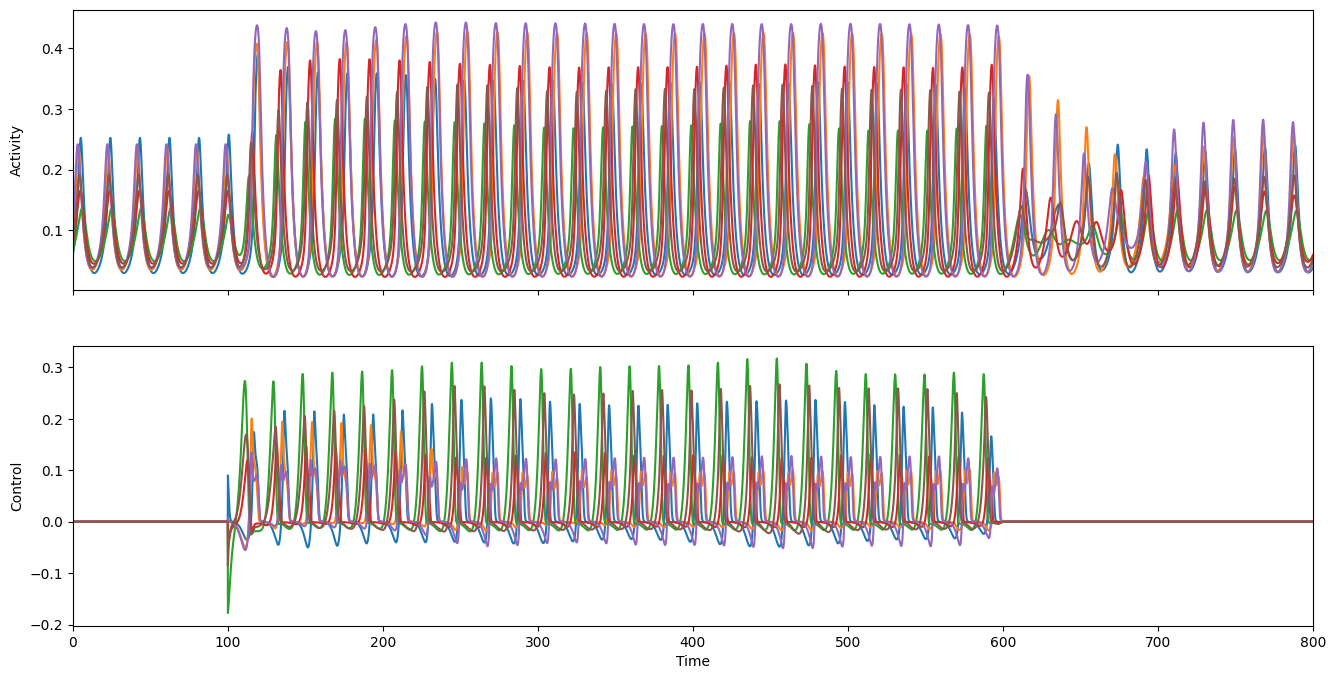

In [209]:
model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.K_gl = coupling

model.params['duration'] = duration
model.params.exc_ext_baseline = coords_desync[0]
model.params.inh_ext_baseline = coords_desync[1]

model.params["exc_init"] = data_desync["init"][0]
model.params["inh_init"] = data_desync["init"][1]
model.run()

for mi, method in enumerate(["F", "CC", "VAR"]):
    #if mi not in [0]: continue

    model_controlled = oc_wc.OcWc(model, period_desync, print_array=pr, cost_interval=cost_interval, control_interval=control_interval,
                                cost_matrix=costmat, control_matrix=controlmat)
    model_controlled.maximum_control_strength = max_cntrl

    model_controlled.optimize(0)
    model_controlled.channelwise_optimization = True

    set_weight_sync(model_controlled, method, data_desync["weights"][mi])
    
    # find initial control signal
    optimize_model(model_controlled, np.arange(-7., 7., 2.), 10)

    model_controlled.grad_method = 1
    optimize_model(model_controlled, np.arange(-7., 7., 2.), 10)

    data_desync["control"][mi] = model_controlled.control.copy()
    data_desync["state"][mi] = model_controlled.get_xs()

    coc = cost_functions.control_strength_cost(data_desync["control"][mi], weights, model.params.dt)
    data_desync["control_cost"][mi] = coc
    data_desync["sync_cost"][mi] = (model_controlled.compute_total_cost() - coc)/data_desync["weights"][mi]

    plot_control(data_desync["control"][mi], data_desync["state"][mi], duration, model.params.dt)

In [ ]:
model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.K_gl = coupling

model.params['duration'] = duration
model.params.exc_ext_baseline = coords_desync[0]
model.params.inh_ext_baseline = coords_desync[1]

model.params["exc_init"] = data_desync["init"][0]
model.params["inh_init"] = data_desync["init"][1]

model.run()

for mi, method in enumerate(["F", "CC", "VAR"]):

    if mi not in [0,2]: continue

    model_controlled = oc_wc.OcWc(model, period_desync, print_array=pr, cost_interval=cost_interval, control_interval=control_interval,
                                cost_matrix=costmat, control_matrix=controlmat)

    set_weight_sync(model_controlled, method, data_desync["weights"][mi])
    model_controlled.maximum_control_strength = max_cntrl

    model_controlled.simulate_forward()
    data_desync["uncontrolled_state"] = model_controlled.get_xs()
    data_desync["uncontrolled_cost"][mi] = model_controlled.compute_total_cost()/data_desync["weights"][mi]

    model_controlled.control = data_desync["control"][mi].copy()
    model_controlled.update_input()

    model_controlled.optimize(0)
    model_controlled.channelwise_optimization = True

    for j in range(30):
        model_controlled.grad_method = 0
        optimize_model(model_controlled, np.arange(-5., 7., 2.), 20)

        model_controlled.grad_method = 1
        optimize_model(model_controlled, np.arange(-5., 7., 2.), 10)

    data_desync["control"][mi] = model_controlled.control.copy()
    data_desync["state"][mi] = model_controlled.get_xs()

    coc = cost_functions.control_strength_cost(data_desync["control"][mi], weights, model.params.dt)
    data_desync["control_cost"][mi] = coc
    data_desync["sync_cost"][mi] = (model_controlled.compute_total_cost() - coc)/data_desync["weights"][mi]

    plot_control(data_desync["control"][mi], data_desync["state"][mi], duration, model.params.dt)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.0102437786311578
Final cost : 0.0102437786311578
Compute control for a deterministic system
Cost in iteration 0: 0.0102437786311578
Converged in iteration 1 with cost 0.0102437786311578
Final cost : 0.0102437786311578
Compute control for a deterministic system
Cost in iteration 0: 0.0102437786311578
Converged in iteration 1 with cost 0.0102437786311578
Final cost : 0.0102437786311578
Compute control for a deterministic system
Cost in iteration 0: 0.0102437786311578
Converged in iteration 1 with cost 0.0102437786311578
Final cost : 0.0102437786311578
Compute control for a deterministic system
Cost in iteration 0: 0.0102437786311578
Converged in iteration 1 with cost 0.0102437786311578
Final cost : 0.0102437786311578
Compute control for a deterministic system
Cost in iteration 0: 0.0102437786311578


In [ ]:
with open(os.path.join(datadir, '3_3.pickle'), 'wb') as f:
    pickle.dump([data_sync, data_desync], f)

In [ ]:
##### import matplotlib as mpl
label_size= 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.linewidth'] = 1

for mi in range(3):
    fig, ax = plt.subplots(3, 2, figsize=(24,12), sharex=True)
    time = np.arange(0, duration+model.params.dt, model.params.dt)

    alpha = 0.2
    for k in [1,2]:
        for j in [0,1]:
            ax[k,j].axvspan(0, 100, color="grey", alpha=alpha)
            ax[k,j].axvspan(600, 800, color="grey", alpha=alpha)

    for n in range(N):
        ax[0,0].plot(time, data_sync["uncontrolled_state"][n,0,:], linewidth=1)
        ax[0,1].plot(time, data_desync["uncontrolled_state"][n,0,:], linewidth=1)
        ax[1,0].plot(time, data_sync["state"][mi][n,0,:], linewidth=1)
        ax[1,1].plot(time, data_desync["state"][mi][n,0,:], linewidth=1)
        ax[2,0].plot(time, data_sync["control"][mi][n,0,:], linewidth=1)
        ax[2,1].plot(time, data_desync["control"][mi][n,0,:], linewidth=1)

    ax[0,0].set_title("Synchronization task")
    ax[0,1].set_title("Desynchronization task")

    xpos = 0.01
    ypos = 0.9

    if mi == 0:
        ax[0,0].text(xpos, ypos, r"$F_\text{F} = $" + "{0:0.2g}".format(data_sync["uncontrolled_cost"][mi]), transform=ax[0,0].transAxes)
        ax[0,1].text(xpos, ypos, r"$F_\text{F} = $" + "{0:0.2g}".format(data_desync["uncontrolled_cost"][mi]), transform=ax[0,1].transAxes)
        ax[1,0].text(xpos, ypos, r"$F_\text{F} = $" + "{0:0.2g}".format(data_sync["sync_cost"][mi]), transform=ax[1,0].transAxes)
        ax[1,1].text(xpos, ypos, r"$F_\text{F} = $" + "{0:0.2g}".format(data_desync["sync_cost"][mi]), transform=ax[1,1].transAxes)
    elif mi == 1:
        ax[0,0].text(xpos, ypos, r"$F_\text{cc} = $" + "{0:0.4f}".format(data_sync["uncontrolled_cost"][mi]), transform=ax[0,0].transAxes)
        ax[0,1].text(xpos, ypos, r"$F_\text{cc} = $" + "{0:0.4f}".format(data_desync["uncontrolled_cost"][mi]), transform=ax[0,1].transAxes)
        ax[1,0].text(xpos, ypos, r"$F_\text{cc} = $" + "{0:0.4f}".format(data_sync["sync_cost"][mi]), transform=ax[1,0].transAxes)
        ax[1,1].text(xpos, ypos, r"$F_\text{cc} = $" + "{0:0.4f}".format(data_desync["sync_cost"][mi]), transform=ax[1,1].transAxes)
    elif mi == 2:
        ax[0,0].text(xpos, ypos, r"$F_\text{var} = $" + "{0:0.4f}".format(data_sync["uncontrolled_cost"][mi]), transform=ax[0,0].transAxes)
        ax[0,1].text(xpos, ypos, r"$F_\text{var} = $" + "{0:0.4f}".format(data_desync["uncontrolled_cost"][mi]), transform=ax[0,1].transAxes)
        ax[1,0].text(xpos, ypos, r"$F_\text{var} = $" + "{0:0.4f}".format(data_sync["sync_cost"][mi]), transform=ax[1,0].transAxes)
        ax[1,1].text(xpos, ypos, r"$F_\text{var} = $" + "{0:0.4f}".format(data_desync["sync_cost"][mi]), transform=ax[1,1].transAxes)
        
    ax[2,0].text(xpos, ypos, r"$F_\text{E} = $" + "{:0.4f}".format(data_sync["control_cost"][mi]), transform=ax[2,0].transAxes)
    ax[2,1].text(xpos, ypos, r"$F_\text{E} = $" + "{:0.4f}".format(data_desync["control_cost"][mi]), transform=ax[2,1].transAxes)

    ax[0,0].set_ylim(0,0.6)
    ax[1,0].set_ylim(0,0.6)
    ax[0,1].set_ylim(0,0.45)
    ax[1,1].set_ylim(0,0.45)

    ax[0,0].set_xlim(0,duration)
    ax[2,0].set_xlabel("Time")
    ax[2,1].set_xlabel("Time")

    ax[0,0].set_ylabel("Uncontrolled activity")
    ax[1,0].set_ylabel("Controlled activity")
    ax[2,0].set_ylabel("Control")

    fig.align_ylabels([ax[:,0]])


    if mi == 0:
        fig.suptitle("Fourier cost")
    elif mi == 1:
        fig.suptitle("Cross-correlation cost")
    elif mi == 2:
        fig.suptitle("Variance cost")

    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    plt.savefig(os.path.join(datadir, "Fig_" + str(mi+8) + ".jpg"), bbox_inches='tight', dpi=300)
    plt.show()

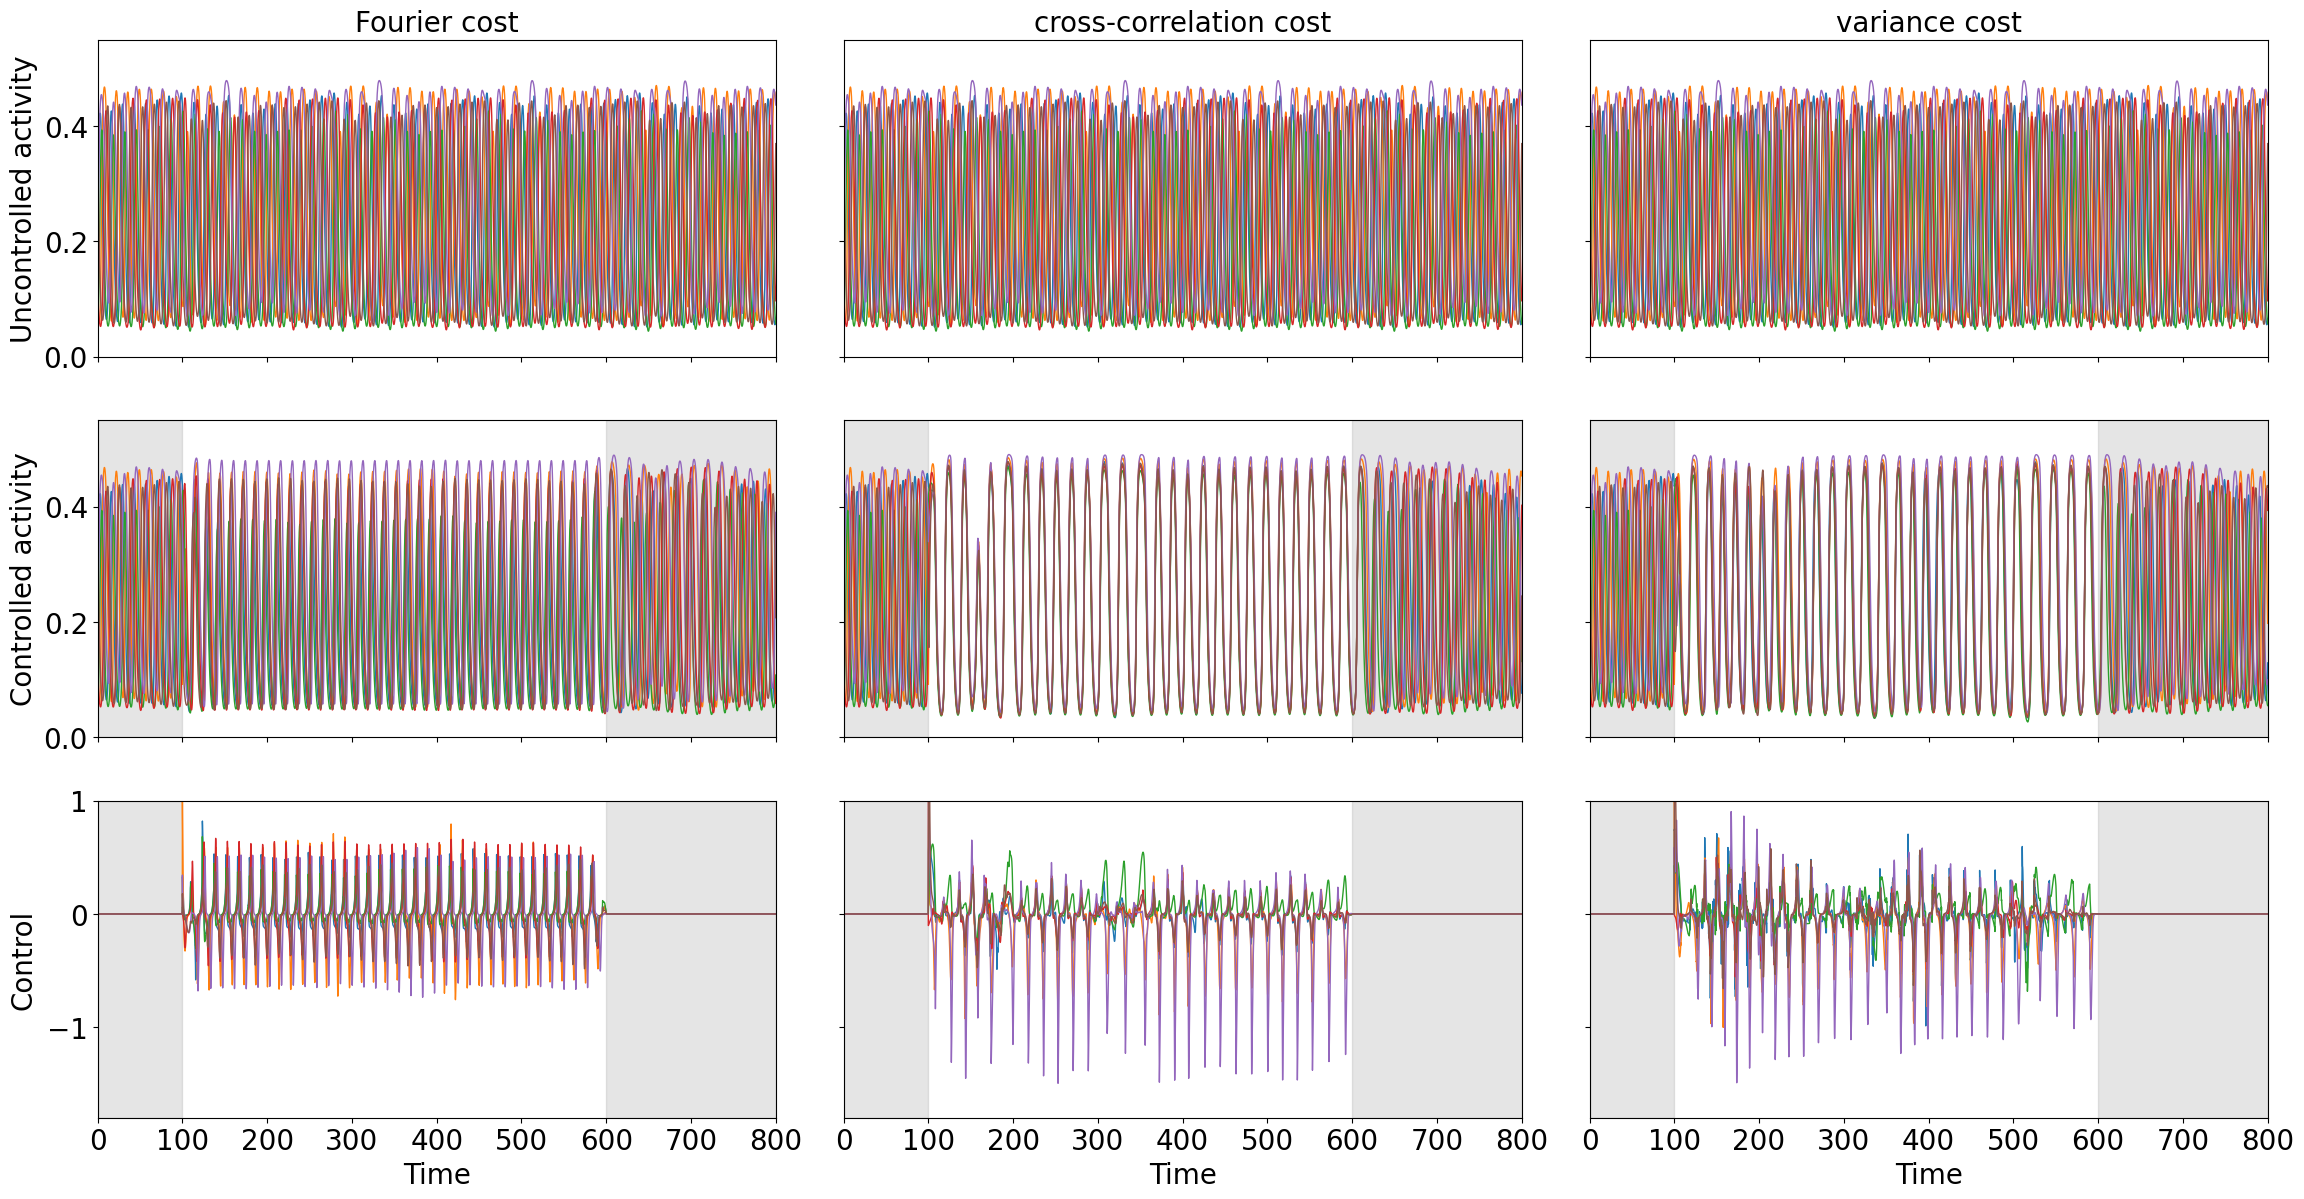

In [305]:
import matplotlib as mpl
label_size= 20
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['font.size'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.linewidth'] = 1

fig, ax = plt.subplots(3, 3, figsize=(28,14), sharey="row", sharex=True)
time = np.arange(0, duration+model.params.dt, model.params.dt)

for mi in range(3):
    for k in [1,2]:
        ax[k,mi].axvspan(0, 100, color="grey", alpha=alpha)
        ax[k,mi].axvspan(600, 800, color="grey", alpha=alpha)

    for n in range(N):
        ax[0,mi].plot(time, data_sync["uncontrolled_state"][n,0,:], linewidth=1)
        ax[1,mi].plot(time, data_sync["state"][mi][n,0,:], linewidth=1)
        ax[2,mi].plot(time, data_sync["control"][mi][n,0,:], linewidth=1)

    ax[2,mi].set_xlabel("Time")

ax[0,0].set_title("Fourier cost")
ax[0,1].set_title("cross-correlation cost")
ax[0,2].set_title("variance cost")

ax[0,0].set_ylim(0,0.55)
ax[1,0].set_ylim(0,0.55)
ax[2,0].set_ylim(-1.8,1.)

ax[0,0].set_xlim(0,duration)

ax[0,0].set_ylabel("Uncontrolled activity")
ax[1,0].set_ylabel("Controlled activity")
ax[2,0].set_ylabel("Control")

fig.align_ylabels([ax[:,0]])

plt.subplots_adjust(wspace=0.1, hspace=0.2)

plt.savefig(os.path.join(datadir, "Fig_Bernstein.jpg"), bbox_inches='tight', dpi=300)
plt.show()